# 5. Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import prml.neural_networks as pn

## 5.1 Feed-forward Network Functions

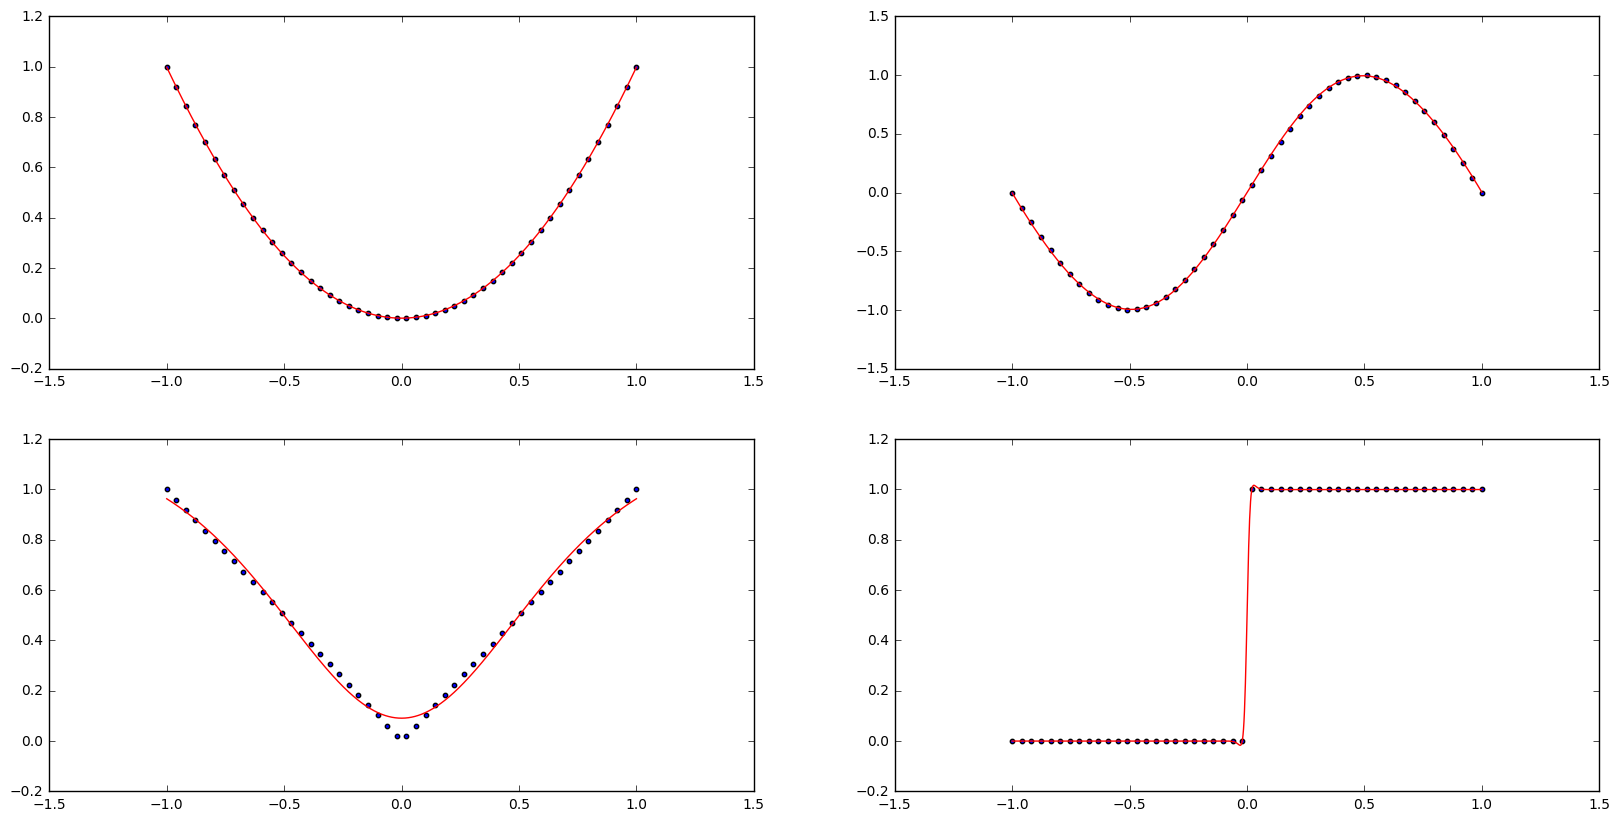

In [2]:
def create_toy_data(func, n=50):
    x = np.linspace(-1, 1, n)[:, None]
    return x, func(x)

def sinusoidal(x):
    return np.sin(np.pi * x)

def heaviside(x):
    return 0.5 * (np.sign(x) + 1)

func_list = [np.square, sinusoidal, np.abs, heaviside]
plt.figure(figsize=(20, 10))
x = np.linspace(-1, 1, 1000)[:, None]
for i, func, n_iter, lr in zip(range(1, 5), func_list, [10000, 10000, 100000, 100000], [1e-2, 1e-2, 1e-4, 1e-3]):
    plt.subplot(2, 2, i)
    x_train, y_train = create_toy_data(func)
    model = pn.Network()
    model.add(pn.layers.MatMul(1, 3))
    model.add(pn.layers.BiasAdd(3))
    model.add(pn.layers.Tanh())
    model.add(pn.layers.MatMul(3, 1))
    model.add(pn.layers.BiasAdd(1))
    cost_func = pn.losses.SquaredError()
    optimizer = pn.optimizers.AdamOptimizer(model, lr)
    for _ in range(n_iter):
        y = model.forward(x_train, training=True)
        delta = cost_func.backward(y, y_train)
        model.backward(delta)
        optimizer.update()
    y = model.forward(x)
    plt.scatter(x_train, y_train, s=10)
    plt.plot(x, y, color="r")
plt.show()

## 5.3 Error Backpropagation

In [3]:
def create_toy_data():
    x = np.random.uniform(-1., 1., size=(100, 2))
    labels = (np.prod(x, axis=1) > 0).astype(np.float)
    return x, labels.reshape(-1, 1)

x_train, y_train = create_toy_data()

model = pn.Network()
model.add(pn.layers.MatMul(2, 4))
model.add(pn.layers.BiasAdd(4))
model.add(pn.layers.Tanh())
model.add(pn.layers.MatMul(4, 1))
model.add(pn.layers.BiasAdd(1))
cost_func = pn.losses.SigmoidCrossEntropy()
optimizer = pn.optimizers.GradientDescentOptimizer(model, 1e-3)

for i in range(100000):
    logit = model.forward(x_train, training=True)
    if i % 10000 == 0:
        cost = cost_func(logit, y_train)
        print("step %6d, cost %f" % (i, cost))
    delta = cost_func.backward(logit, y_train)
    model.backward(delta)
    optimizer.update()

step      0, cost 76.703541
step  10000, cost 4.367946
step  20000, cost 3.137029
step  30000, cost 2.629884
step  40000, cost 2.333582
step  50000, cost 2.130892
step  60000, cost 1.979682
step  70000, cost 1.860517
step  80000, cost 1.762945
step  90000, cost 1.680749


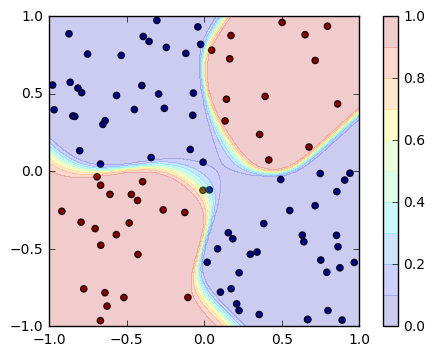

In [4]:
x0, x1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
x = np.array([x0, x1]).reshape(2, -1).T
logit = model.forward(x).reshape(100, 100)
y = cost_func.forward(logit)

levels = np.linspace(0, 1, 11)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x0, x1, y, levels, alpha=0.2)
plt.colorbar()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 5.5 Regularization in Neural Networks

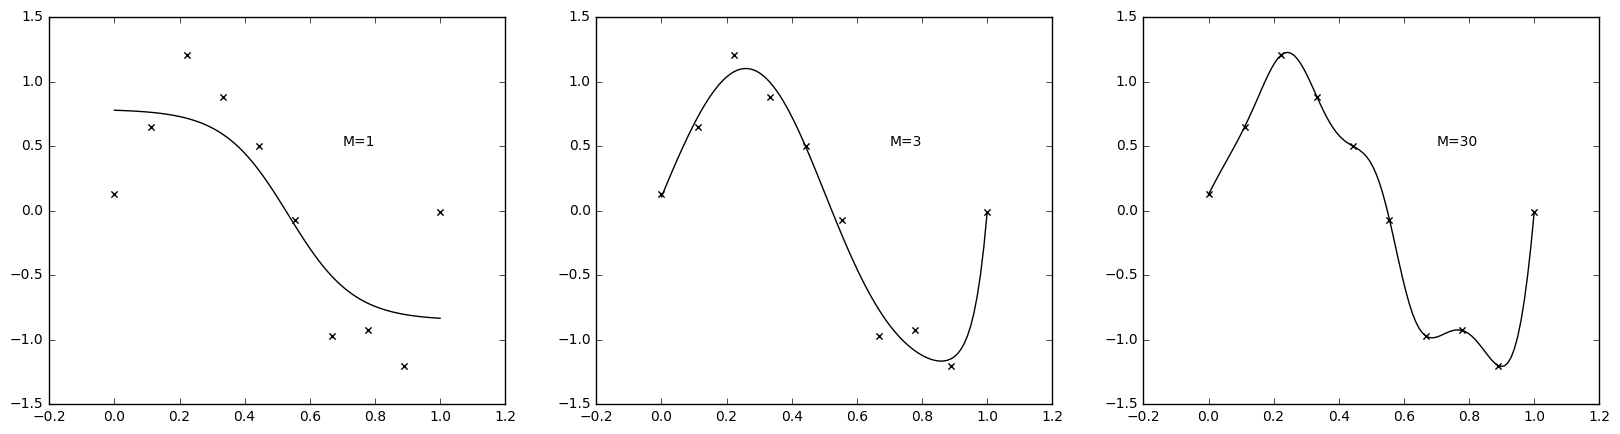

In [5]:
def create_toy_data(n=10):
    x = np.linspace(0, 1, n)[:, None]
    return x, np.sin(2 * np.pi * x) + np.random.normal(scale=0.25, size=(10, 1))

x_train, y_train = create_toy_data()
x = np.linspace(0, 1, 100)[:, None]

plt.figure(figsize=(20, 5))
for i, m in enumerate([1, 3, 30]):
    plt.subplot(1, 3, i + 1)
    model = pn.Network()
    model.add(pn.layers.MatMul(1, m))
    model.add(pn.layers.BiasAdd(m))
    model.add(pn.layers.Tanh())
    model.add(pn.layers.MatMul(m, 1))
    model.add(pn.layers.BiasAdd(1))
    cost_func = pn.losses.SquaredError()
    optimizer = pn.optimizers.AdamOptimizer(model)
    for j in range(10000 * m):
        y = model.forward(x_train, training=True)
        delta = cost_func.backward(y, y_train)
        model.backward(delta)
        optimizer.update()
    y = model.forward(x)
    plt.scatter(x_train, y_train, marker="x", color="k")
    plt.plot(x, y, color="k")
    plt.annotate("M={}".format(m), (0.7, 0.5))
plt.show()

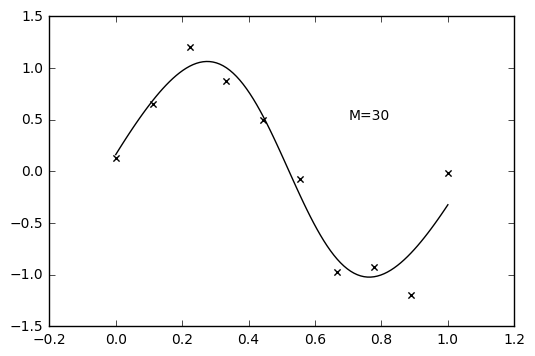

In [6]:
model = pn.Network()
model.add(pn.layers.MatMul(1, 30))
model.add(pn.layers.BiasAdd(30))
model.add(pn.layers.Tanh())
model.add(pn.layers.MatMul(30, 1))
model.add(pn.layers.BiasAdd(1))
cost_func = pn.losses.SquaredError()
penalty_func = pn.losses.WeightDecay(1e-2)
optimizer = pn.optimizers.AdamOptimizer(model)
for i in range(300000):
    y = model.forward(x_train, training=True)
    delta = cost_func.backward(y, y_train)
    model.backward(delta)
    penalty_func.backward(model)
    optimizer.update()
y = model.forward(x)
plt.scatter(x_train, y_train, marker="x", color="k")
plt.plot(x, y, color="k")
plt.annotate("M=30", (0.7, 0.5))
plt.show()

In [7]:
def create_toy_data():
    x = np.random.uniform(-1., 1., size=(100, 2))
    labels = (np.prod(x, axis=1) > 0).astype(np.float)
    return x, labels.reshape(-1, 1)

x_train, y_train = create_toy_data()

model_mle = pn.Network()
model_mle.add(pn.layers.MatMul(2, 4))
model_mle.add(pn.layers.BiasAdd(4))
model_mle.add(pn.layers.Tanh())
model_mle.add(pn.layers.MatMul(4, 1))
model_mle.add(pn.layers.BiasAdd(1))

model_map = pn.Network()
model_map.add(pn.layers.MatMul(2, 4))
model_map.add(pn.layers.BiasAdd(4))
model_map.add(pn.layers.Tanh())
model_map.add(pn.layers.MatMul(4, 1))
model_map.add(pn.layers.BiasAdd(1))

cost_func = pn.losses.SigmoidCrossEntropy()
penalty_func = pn.losses.WeightDecay(1.)
optimizer_mle = pn.optimizers.GradientDescentOptimizer(model_mle, 1e-3)
optimizer_map = pn.optimizers.GradientDescentOptimizer(model_map, 1e-3)

for i in range(100000):
    logit_mle = model_mle.forward(x_train, training=True)
    logit_map = model_map.forward(x_train, training=True)
    delta_mle = cost_func.backward(logit_mle, y_train)
    delta_map = cost_func.backward(logit_map, y_train)
    model_mle.backward(delta_mle)
    model_map.backward(delta_map)
    penalty_func.backward(model_map)
    optimizer_mle.update()
    optimizer_map.update()

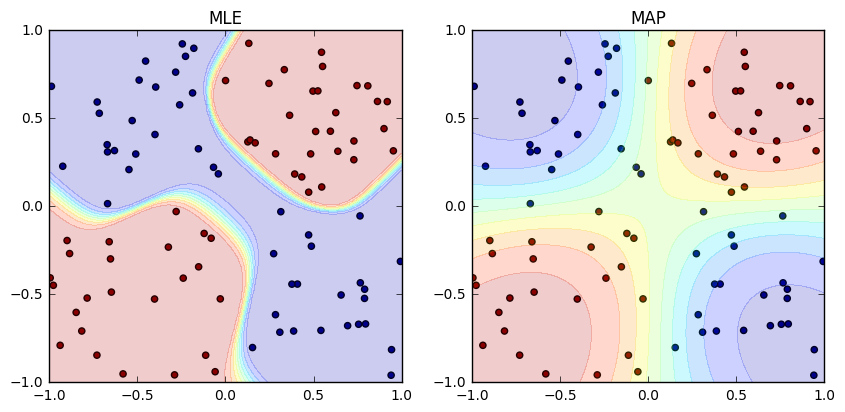

In [8]:
x0, x1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
x = np.array([x0, x1]).reshape(2, -1).T
y_mle = cost_func.forward(model_mle.forward(x)).reshape(100, 100)
y_map = cost_func.forward(model_map.forward(x)).reshape(100, 100)

levels = np.linspace(0, 1, 11)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x0, x1, y_mle, levels, alpha=0.2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("MLE")
plt.subplot(1, 2, 2)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x0, x1, y_map, levels, alpha=0.2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("MAP")
plt.show()

## 5.6 Mixture Density Networks

In [9]:
def create_toy_data(func, n=300):
    t = np.random.uniform(size=(n, 1))
    x = func(t) + np.random.uniform(-0.05, 0.05, size=(n, 1))
    return x, t

def func(x):
        return x + 0.3 * np.sin(2 * np.pi * x)
    
def sample(x, t, n=None):
    assert len(x) == len(t)
    N = len(x)
    if n is None:
        n = N
    indices = np.random.choice(N, n, replace=False)
    return x[indices], t[indices]

x_train, y_train = create_toy_data(func)

In [10]:
model = pn.Network()
model.add(pn.layers.MatMul(1, 5, std=0.1))
model.add(pn.layers.BiasAdd(5))
model.add(pn.layers.Tanh())
model.add(pn.layers.MatMul(5, 9, std=0.1))
model.add(pn.layers.BiasAdd(9))
cost_func = pn.losses.GaussianMixtureNLL(n_components=3)
optimizer = pn.optimizers.AdamOptimizer(model, 1e-4)

for i in range(100000):
    batch = sample(x_train, y_train, n=100)
    logit = model.forward(batch[0], training=True)
    delta = cost_func.backward(logit, batch[1])
    model.backward(delta)
    optimizer.update()

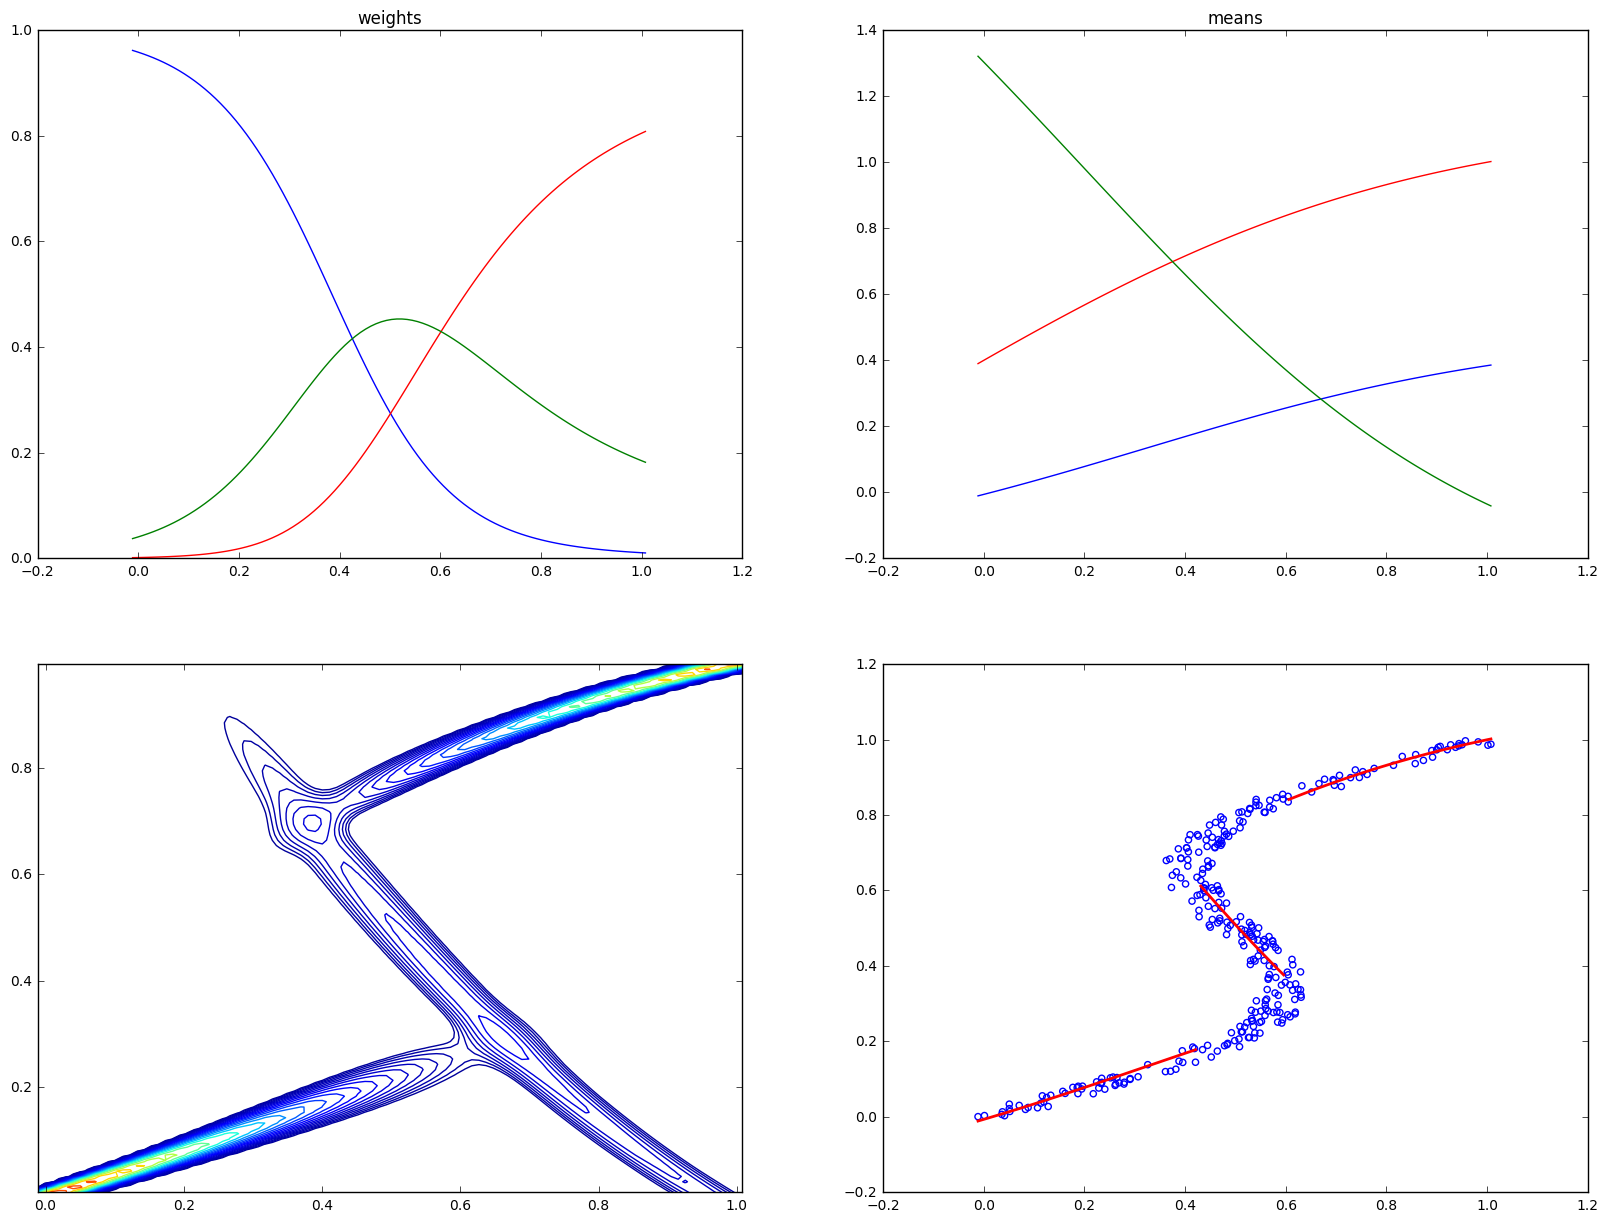

In [11]:
x, y = np.meshgrid(
    np.linspace(x_train.min(), x_train.max(), 100),
    np.linspace(y_train.min(), y_train.max(), 100))
xy = np.array([x, y]).reshape(2, -1).T

logit = model.forward(xy[:, 0].reshape(-1, 1))
sigma, weight, mu = cost_func.forward(logit)
probs = cost_func.gauss(mu, sigma, xy[:, 1].reshape(-1, 1))
probs = np.sum(weight * probs, axis=1).reshape(100, 100)

plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(x[0], weight[:100, 0], color="blue")
plt.plot(x[0], weight[:100, 1], color="red")
plt.plot(x[0], weight[:100, 2], color="green")
plt.title("weights")

plt.subplot(2, 2, 2)
plt.plot(x[0], mu[:100, 0], color="blue")
plt.plot(x[0], mu[:100, 1], color="red")
plt.plot(x[0], mu[:100, 2], color="green")
plt.title("means")

plt.subplot(2, 2, 3)
levels_log = np.linspace(0, np.log(probs.max()), 21)
levels = np.exp(levels_log)
levels[0] = 0
plt.contour(x, y, probs, levels)
plt.xlim(x_train.min(), x_train.max())
plt.ylim(y_train.min(), y_train.max())

plt.subplot(2, 2, 4)
argmax = np.argmax(weight[:100], axis=1)
for i in range(3):
    indices = np.where(argmax == i)[0]
    plt.plot(x[0, indices], mu[(indices, np.zeros_like(indices) + i)], color="r", linewidth=2)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b")
plt.show()

## 5.7 Bayesian Neural Networks